In [2]:
import os
import re
import sys
import time
from io import StringIO
import matplotlib.pyplot as plt

import pandas as pd
import requests

BASEURL = "https://fallingstar-data.com/forcedphot"
# BASEURL = "http://127.0.0.1:8000"

In [ ]:
from getpass import getpass
#! sudo apt-get install sshpass

user = 't.e.muller-bravo'
password = getpass('Password:')

In [19]:
if os.environ.get('ATLASFORCED_SECRET_KEY'):
    token = os.environ.get('ATLASFORCED_SECRET_KEY')
    print('Using stored token')
else:
    data = {'username': user, 'password': password}

    resp = requests.post(url=f"{BASEURL}/api-token-auth/", data=data)

    if resp.status_code == 200:
        token = resp.json()['token']
        print(f'Your token is {token}')
        print('Store this by running/adding to your .zshrc file:')
        print(f'export ATLASFORCED_SECRET_KEY="{token}"')
    else:
        print(f'ERROR {resp.status_code}')
        print(resp.text)
        sys.exit()


headers = {'Authorization': f'Token {token}', 'Accept': 'application/json'}

task_url = None
while not task_url:
    with requests.Session() as s:
        # alternative to token auth
        # s.auth = ('USERNAME', 'PASSWORD')
        resp = s.post(f"{BASEURL}/queue/", headers=headers, data={
            'ra': 239.6715, 'dec': 11.24024, 'mjd_min': 58634.35076625, 'send_email': False})

        if resp.status_code == 201:  # successfully queued
            task_url = resp.json()['url']
            print(f'The task URL is {task_url}')
        elif resp.status_code == 429:  # throttled
            message = resp.json()["detail"]
            print(f'{resp.status_code} {message}')
            t_sec = re.findall(r'available in (\d+) seconds', message)
            t_min = re.findall(r'available in (\d+) minutes', message)
            if t_sec:
                waittime = int(t_sec[0])
            elif t_min:
                waittime = int(t_min[0]) * 60
            else:
                waittime = 10
            print(f'Waiting {waittime} seconds')
            time.sleep(waittime)
        else:
            print(f'ERROR {resp.status_code}')
            print(resp.text)
            sys.exit()


result_url = None
taskstarted_printed = False
while not result_url:
    with requests.Session() as s:
        resp = s.get(task_url, headers=headers)

        if resp.status_code == 200:  # HTTP OK
            if resp.json()['finishtimestamp']:
                result_url = resp.json()['result_url']
                print(f"Task is complete with results available at {result_url}")
            elif resp.json()['starttimestamp']:
                if not taskstarted_printed:
                    print(f"Task is running (started at {resp.json()['starttimestamp']})")
                    taskstarted_printed = True
                time.sleep(2)
            else:
                print(f"Waiting for job to start (queued at {resp.json()['timestamp']})")
                time.sleep(4)
        else:
            print(f'ERROR {resp.status_code}')
            print(resp.text)
            sys.exit()

with requests.Session() as s:
    textdata = s.get(result_url, headers=headers).text

    # if we'll be making a lot of requests, keep the web queue from being
    # cluttered (and reduce server storage usage) by sending a delete operation
    # s.delete(task_url, headers=headers).json()

dfresult = pd.read_csv(StringIO(textdata.replace("###", "")), delim_whitespace=True)

Your token is 6545448b543e51217af852e5878fdf4b13d58aec
Store this by running/adding to your .zshrc file:
export ATLASFORCED_SECRET_KEY="6545448b543e51217af852e5878fdf4b13d58aec"
The task URL is https://fallingstar-data.com/forcedphot/queue/197128/
Waiting for job to start (queued at 2022-04-28T17:31:15Z)
Task is running (started at 2022-04-28T17:31:19Z)
Task is complete with results available at https://fallingstar-data.com/forcedphot/queue/197128/data.txt
Ready


In [20]:
dfresult.head()

,MJD,m,dm,uJy,duJy,F,err,chi/N,RA,Dec,x,y,maj,min,phi,apfit,mag5sig,Sky,Obs
0,58635.446141,20.691,0.351,19,7,c,0,2.15,239.6715,11.24024,2685.50,928.36,2.61,2.31,-57.3,-0.430,19.81,21.83,02a58635o0445c
1,58635.453534,20.571,0.412,22,9,c,0,1.44,239.6715,11.24024,2669.40,890.04,2.56,2.26,-62.6,-0.430,19.69,21.91,02a58635o0458c
2,58635.458848,21.596,0.896,8,8,c,0,1.50,239.6715,11.24024,2728.47,968.33,2.52,2.30,-60.0,-0.428,19.80,21.83,02a58635o0468c
3,58635.469402,19.850,0.180,42,8,c,0,1.45,239.6715,11.24024,2745.79,851.09,2.56,2.32,-56.6,-0.428,19.83,21.82,02a58635o0488c
4,58637.449986,20.805,0.578,17,10,o,0,1.83,239.6715,11.24024,6312.86,7575.68,2.79,2.75,24.6,-0.466,19.33,21.10,01a58637o0133o


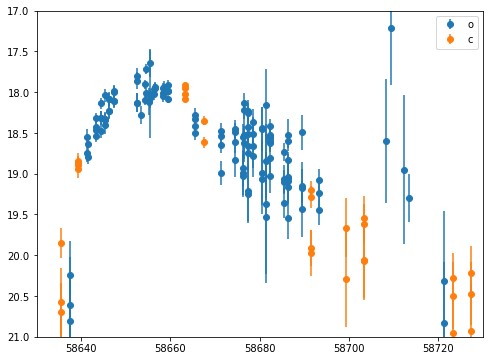

In [31]:
test_df = dfresult[dfresult.m>0]
test_df = test_df[test_df.dm<1]

fig, ax = plt.subplots(figsize=(8, 6))
for filt in test_df.F.unique()[::-1]:
    df = test_df[test_df.F==filt]
    ax.errorbar(df.MJD, df.m, yerr=df.dm, fmt='o', label=filt)
#ax.set_title(test_oid)
ax.set_xlim(58630, 58730)
ax.set_ylim(17, 21)
ax.invert_yaxis()
ax.legend()